In [1]:
import jax.numpy as jnp
import jax
import numpy as np

import src.models
import orbax.checkpoint
from src.training import utils

In [ ]:
# from experiments.ou import train_score_fixed_endpt
# 
# dims = np.arange(29, 32)
# key = jax.random.PRNGKey(1)
# for dim in dims:
#     train_score_fixed_endpt.main(key, dim)

Setup to load in checkpoint

In [2]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

T = 1.0
N = 100

def get_score(dim):
    checkpoint_path = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou/reverse/fixed_y_1_d_{dim}"
    restored = orbax_checkpointer.restore(checkpoint_path)
    model = src.models.score_mlp.ScoreMLP(**restored["network"])
    params = restored["params"]
    trained_score = utils.trained_score(model, params)
    sde = restored["sde"]
    return trained_score, sde


def get_score_forward(dim):
    x0 = jnp.ones(shape=(dim,))
    checkpoint_path = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou/forward/fixed_x0_{x0}"
    restored = orbax_checkpointer.restore(checkpoint_path)
    model = src.models.score_mlp.ScoreMLP(**restored["network"])
    params = restored["params"]
    trained_score = utils.trained_score(model, params)
    sde = restored["sde"]
    return trained_score, sde


Find errors for different d and T

In [3]:
def error(ts, true_score, trained_score, sde, x0):
    """mean squared error between true and trained score"""
    true = jax.vmap(true_score, in_axes=(0, None, None, None))(ts, x0, sde["T"], sde["y"])
    trained = jax.vmap(trained_score, in_axes=(0, None))(ts, x0)
    return jnp.mean((true - trained) ** 2)

def error_forward(ts, true_score, trained_score, sde, y):
    """mean squared error between true and trained score"""
    true = jax.vmap(true_score, in_axes=(None, None, 0, None))(0, sde["x0"], ts, y)
    trained = jax.vmap(trained_score, in_axes=(0, None))(ts, y)
    return jnp.mean((true - trained) ** 2)

In [ ]:
# errors = []

# true_score = sde_ornstein_uhlenbeck.score
# for d in ds:
#     trained_score_, sde_ = get_score(d)
#     error_d_ = error(ts[:-1], true_score, trained_score_, sde_, sde_["x0"])
#     errors.append(error_d_)
# np.save("ou_errors_reverse_dim_1_to_32.npy", errors)

# forward_errors = []
# true_score_forward = sde_ornstein_uhlenbeck.score_forward
# for d in ds:
#     trained_score_, sde_ = get_score_forward(d)
#     error_d_ = error_forward(ts[1:], true_score_forward, trained_score_, sde_, sde_["y"])
#     forward_errors.append(error_d_)   
# np.save("ou_errors_forward_dim_1_to_32.npy", forward_errors)

In [15]:
from tueplots import bundles, axes, cycler
from tueplots.constants.color import palettes
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)
axes.lines()
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))




Error plots for different d

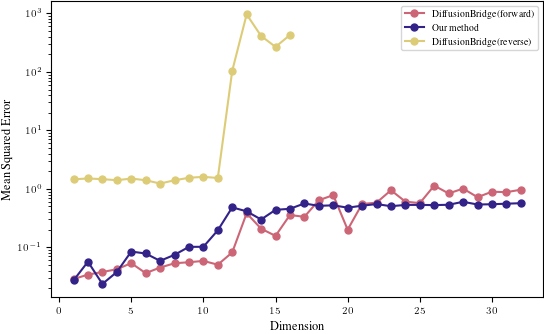

In [22]:
from src.data_generate_sde import sde_ornstein_uhlenbeck, time

ds = np.arange(1, 33)
ts = time.grid(0, T, 100)


errors = np.load("dimensions/ou_errors_reverse_dim_1_to_32.npy")    
errors_diffusion_bridge = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/diffusion_bridge_errors_forward_dims_1_to_32.npy")
errors_diffusion_bridge_reverse = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/diffusion_bridge_errors_backward_dims_1_to_16.npy")

plt.semilogy(ds, errors_diffusion_bridge, "o-", label="DiffusionBridge (forward)", markersize=5)
plt.semilogy(ds, errors, "o-", label="Our method", markersize=5)
plt.semilogy(ds[:16], errors_diffusion_bridge_reverse, "o-", label="DiffusionBridge (reverse)", markersize=5)
# plt.semilogx(ds, forward_errors, "o-", label="Forward")
plt.legend()
# plt.xticks(ds, ds)
plt.xlabel("Dimension")
plt.ylabel("Mean Squared Error")
# plt.ylim((-1, 5))
plt.savefig("dim_comparison.pdf")
plt.show()





<Figure size 550x339.919 with 0 Axes>